## UMAP для метода Якоби решения уравнения Пуассона

Запомним шаги метода Якоби:

In [0]:
%matplotlib inline
import matplotlib
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
matplotlib.rcParams.update({'font.size': 16})
import seaborn as sns
plt.rcParams['figure.figsize'] = (10,5)

sns.set()

In [0]:
def solve_poisson(N, u, f, tol = 1e-3, max_it = 1e+4, print_every=100):
    """
    N-1 --- количество внутренних узлов сетки
    u --- массив с заданными граничными условиями размера (N+1, N+1)
    f --- массив (N-1, N-1), правая часть уравнения Пуассона
    tol --- относительная неувязка по целевой функции
    max_it --- макимальное количество операций
    """
    h = 1.0/N
    u_new = u.copy()
    x = np.arange(N+1) * h # x = i * h, i = 0,...,N
    y = np.arange(N+1) * h # y = j * h, j = 0,...,N
    history = np.zeros((N + 1, N + 1, np.int(max_it) // print_every + 1))
    it = 0
    h_step = 0
    x_index = np.repeat(np.arange(1, N)[:, np.newaxis], N-1, axis=1)
    y_index = np.repeat(np.arange(1, N)[np.newaxis, :], N-1, axis=0)
    while True:
        u = np.copy(u_new)
        u_new[x_index, y_index] = 0.25 * (u[x_index + 1, y_index] + 
                                        u[x_index - 1, y_index] + 
                                        u[x_index, y_index + 1] + 
                                        u[x_index, y_index - 1] - h ** 2 * f)
        delta = np.max(np.abs(u_new - u)) / np.max(np.abs(u_new))
        if (it % print_every == 0):
            history[:, :, h_step] = u_new
            h_step = h_step + 1
        it = it + 1
        if ((delta < tol) or (it > max_it)):
            break
    history = history[:, :, :h_step]
    return u_new.T, x, y, it, delta, history

Загрузим UMAP:

In [0]:
from umap.umap_ import UMAP

Зададим начальные условия. Пусть они будут гладкими:

$$
G = [0, 1] \times [0, 1]
$$

$$
u(x, y) = sin(2 \pi x), \; (x,y ) \in [0, 1] \times \{0\}
$$

Остальные границы аналогично.

In [0]:
N = 200
u = np.zeros((N+1, N+1))
u[:, 0] = np.sin(2 * np.pi * np.linspace(0, 1, N + 1))
u[0, :] = np.sin(2 * np.pi * np.linspace(0, 1, N + 1))
u[:, -1] = np.sin(2 * np.pi * np.linspace(0, 1, N+1))
u[-1, :] = np.sin(2 * np.pi * np.linspace(0, 1, N+1))

X = np.linspace(0, 1, N - 1)
Y = np.linspace(0, 1, N - 1)
X, Y = np.meshgrid(X, Y)
f = (X - Y) * 10

Решаем методом Якоби:

In [38]:
u, x, y, max_it, delta, history = solve_poisson(N, u, f, 
                                                print_every=200, tol=1e-5)
max_it, delta

(8211, 9.997631002123253e-06)

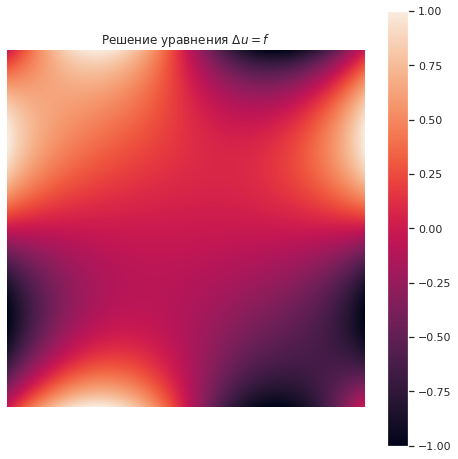

In [39]:
fig = plt.figure(figsize=(8, 8))
im = plt.imshow(u)
fig.colorbar(im)
plt.axis('off')
plt.title('Решение уравнения $\Delta u = f$')
plt.show()

Шаги метода:

In [0]:
steps = history.shape[-1] // 5
steps

16

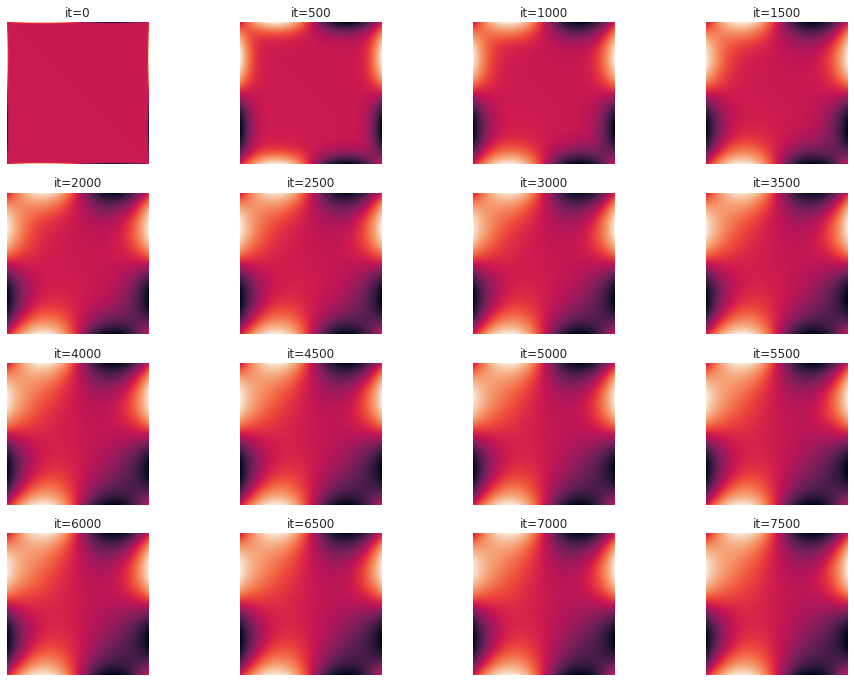

In [0]:
plt.figure(figsize=(16,12))
for step in range(steps):
    ax = plt.subplot(4, 4, step + 1)
    ax.axis('off')
    ax.imshow(history[:, :, step * 5])
    ax.set_title(f'it={step * 5 * 100}')

Визуализируем сходимость с помощью UMAP. Двумерный случай:

In [0]:
reducer = UMAP(n_neighbors=10, min_dist=0.5)
transformed = reducer.fit_transform(history.reshape(history.shape[-1], -1))

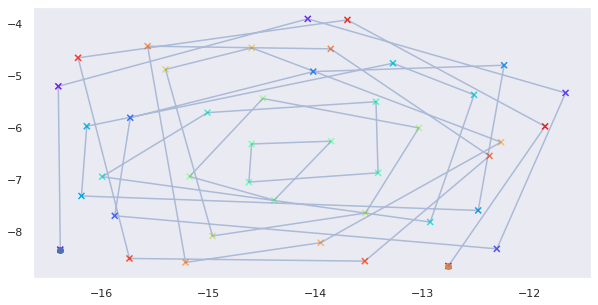

In [42]:
plt.plot(transformed[:, 0], transformed[:, 1], alpha=0.4)
plt.scatter(transformed[:, 0], transformed[:, 1], 
            color = cm.rainbow(np.linspace(0, 1, history.shape[-1])), marker='x')
plt.scatter(transformed[0, 0], transformed[0, 1], marker='o')
plt.scatter(transformed[-1, 0], transformed[-1, 1], marker='o')
plt.grid()
plt.show()

Синие точки --- начало траектории метода, красные -- его окончание.

Это очень странный результат. Судя по нему, середина траектории метода Якоби дальше от конечной точки, чем исходная.

Посмотрим на реализацию в трехмерном пространстве:

In [0]:
reducer = UMAP(n_neighbors=10, min_dist=0.5, n_components=3)
transformed = reducer.fit_transform(history.reshape(history.shape[-1], -1))

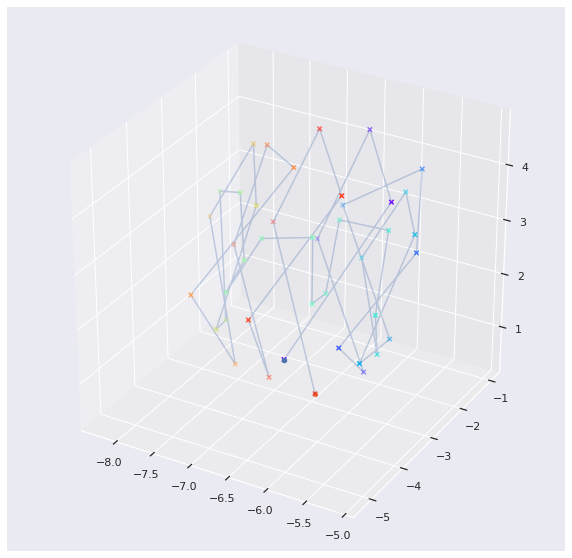

In [44]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot(transformed[:, 0], transformed[:, 1], transformed[:, 2], alpha=0.3)
ax.scatter(transformed[:, 0], transformed[:, 1], transformed[:, 2],
           color = cm.rainbow(np.linspace(0, 1, history.shape[-1])), marker='x')
ax.scatter(transformed[0, 0], transformed[0, 1], transformed[0, 2], marker='o')
ax.scatter(transformed[-1, 0], transformed[-1, 1], transformed[-1, 2])
plt.show()

Получившийся график подтверждает нашу гипотезу. UMAP основывается на расстояниях между точками и игнорирует то, что между предыдущем вектором и последующим есть аффинная связь, а значит при применении UMAP мы эту связь потеряем. Движение же остается хаотичным.

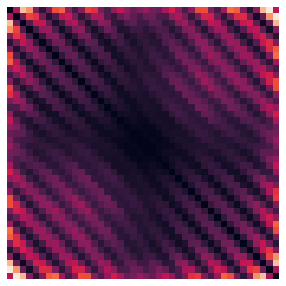

In [45]:
history_shaped = history.reshape(history.shape[-1], -1)
squares = (history_shaped ** 2).sum(axis=1)
H = squares.reshape(-1, 1) + squares.reshape(1, -1)
pair_distances = H - 2 * history_shaped @ history_shaped.T
# при вычитании образовались сверхмалые значения, оказавшиеся отрицательными
# приравняем их к нулю
plt.imshow(np.maximum(pair_distances, 0))
plt.axis('off')
plt.show()

Видно, что UMAP не врет, и метод Якоби движется по какой-то спирали.

Попробуем другие данные.

In [0]:
N = 100
T1 = 300
T2 = 500
u = np.zeros((N+1, N+1)) # initialize 2-d solution array
x = np.linspace(0, 1, N + 1)
y = np.linspace(0, 1, N + 1)
u[:, 0] = T1 
u[0, :] = T1
u[:, N] = np.where(np.logical_or(x<0.4, x>0.6), T1, T2)         
u[N, :] = np.where(np.logical_or(y<0.2, y>0.8), T1, T2)
f = -900

In [31]:
u, x, y, max_it, delta, history = solve_poisson(N, u, f, 
                                                print_every=N, tol=1e-5)
max_it, delta

(8447, 9.990763795030943e-06)

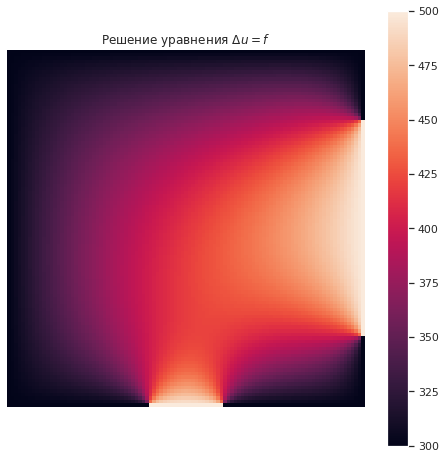

In [32]:
fig = plt.figure(figsize=(8, 8))
im = plt.imshow(u)
fig.colorbar(im)
plt.axis('off')
plt.title('Решение уравнения $\Delta u = f$')
plt.show()

In [0]:
reducer = UMAP(n_neighbors=30, min_dist=0.5)
transformed = reducer.fit_transform(history.reshape(history.shape[-1], -1))

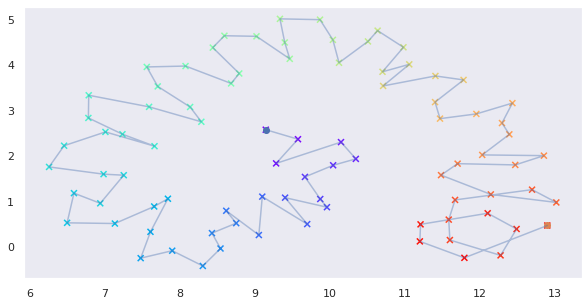

In [34]:
plt.plot(transformed[:, 0], transformed[:, 1], alpha=0.4)
plt.scatter(transformed[:, 0], transformed[:, 1], 
            color = cm.rainbow(np.linspace(0, 1, history.shape[-1])), marker='x')
plt.scatter(transformed[0, 0], transformed[0, 1], marker='o')
plt.scatter(transformed[-1, 0], transformed[-1, 1], marker='o')
plt.grid()
plt.show()

In [0]:
reducer = UMAP(n_neighbors=30, min_dist=0.5, n_components=3)
transformed = reducer.fit_transform(history.reshape(history.shape[-1], -1))

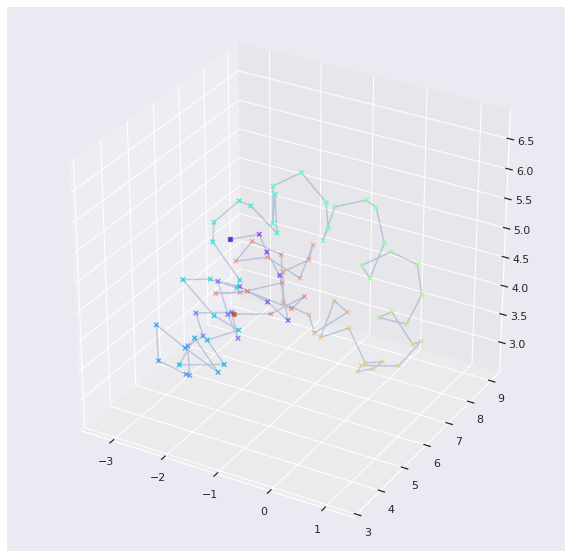

In [36]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot(transformed[:, 0], transformed[:, 1], transformed[:, 2], alpha=0.3)
ax.scatter(transformed[:, 0], transformed[:, 1], transformed[:, 2],
           color = cm.rainbow(np.linspace(0, 1, history.shape[-1])), marker='x')
ax.scatter(transformed[0, 0], transformed[0, 1], transformed[0, 2], marker='o')
ax.scatter(transformed[-1, 0], transformed[-1, 1], transformed[-1, 2])
plt.show()

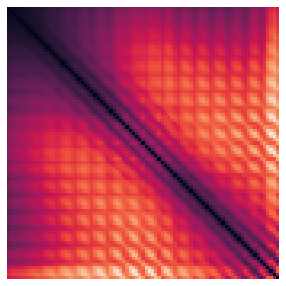

In [0]:
history_shaped = history.reshape(history.shape[-1], -1)
squares = (history_shaped ** 2).sum(axis=1)
H = squares.reshape(-1, 1) + squares.reshape(1, -1)
pair_distances = H - 2 * history_shaped @ history_shaped.T
# при вычитании образовались сверхмалые значения, оказавшиеся отрицательными
# приравняем их к нулю
plt.imshow(np.maximum(pair_distances, 0))
plt.axis('off')
plt.show()

Видно, что последовательность решений предсказывать смысла нет: она образует мягко говоря не оптимальную траекторию. Она будто нарезывает круги или движется по спирали. Когда мы ставили более высокое разрешение, метод не успевал сходится. В этот момент отчетливо было видно, что метод движется по кругу. Интересно, что графики расстояний напоминают график самой функции.

Причина нарезания кругов может быть следующая: возможно, алгортм Якоби есть некоторый процесс затухающих колебаний. Причем, когда $f \neq 0$, у алгоритма есть направление движения. Когда же $f = 0$, то алгоритм движется по кругу. Таким образом, графики окажутся наиболее презентабельными, если запись в истории делается кратно размеру стеки $N$. При этом даже траектория самих этих записей оказывается закрученной.